We have to add the `git` repositories of `scanpy`, `anndata` and `anndata2ri` to the search path for Python packages, otherwise the notebook won't load the most recent packages.

In [25]:
import sys
import os, fnmatch 

In [26]:
sys.path.append('/home/icb/maren.buettner/Python/scanpy/')
sys.path.append('/home/icb/maren.buettner/Python/anndata/')
sys.path.append('/home/icb/maren.buettner/Python/anndata2ri/')

In [27]:
import anndata
import scanpy as sc
import scipy as sci
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.2.0
anndata2ri                  1.1
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
cffi                        1.15.0
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.6.3
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.10.0
google                      NA
h5py                        3.7.0
hypergeom_ufunc             NA
igraph                      0.10.1
ipykernel                   6.15.1
ipython_genutils            0.2.0
ipywidgets                  8.0.1
jedi                        0.18.1
jinja2                      3.1.2
joblib                      1.1.0
kiwisolver                  1.4.4
llvmlite                    0.39.0
louvain                     0.8.0
markupsafe     

In [28]:
sc.settings.verbosity = 3

In [29]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import datetime
now = datetime.datetime.now()
today = now.strftime("%Y%m%d")

In [30]:
import rpy2.rinterface_lib.callbacks
import logging
import anndata2ri

from rpy2.robjects import pandas2ri

In [31]:
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Introduction

We integrate several datasets, which studied the mouse brain or which contain mouse brain cell data. These datasets are partly annotated. We summarize the dataset in the following table.

|study | sample size | annotated| brain regions annotated| 
|------|-------------|----------|------------------------|
|Saunders (2018, Cell) | 690k | yes | yes |
|Zeisel (2018, Cell) | 160k | yes | yes |
|Rosenberg (2018, Science) | 133k (brain and spinal cord) | yes | partially |

We include the following data sets in our analysis from Tabula Muris, Saunders et al, Zeisel et al, and Rosenberg et al. This yields 978k cells in total. 

# Read data

## Saunders et al (2018)
This study sequenced 690k cells from several regions of the mouse brain to create an atlas of the cell type specialisation. The authors provide data sets sorted by brain region, which contains much more cells than the 'by class' files. The problem here is that the 'by region' files contain also low-quality cells. 

The authors provided additional 'outcome' files containing the cell annotation and if it was filtered out or not. We will use the cluster information from these files to annotate the cells.

We downloaded the data files and the 'outcome' files separated by region from http://dropviz.org/.

In [35]:
path_dir = './../../DL_annotation/mouse_brain_data/Saunders_2018/'
listOfFiles = os.listdir(path= path_dir)

Convert the cell annotations from the R object `RDS` file format to `csv`.

In [36]:
%%R -i path_dir 

filelist <- list.files(path_dir, pattern='.RDS')

for (file_idx in filelist){
  file_out <- gsub('.RDS', '.csv', file_idx)
  data = readRDS(paste0(path_dir, file_idx))
  write.csv(x = data, file = paste0(path_dir, file_out), quote = FALSE)
}

Read `dge` files and convert them to `anndata` objects. 

Please note that `dge` files states first all gene names, then the barcodes, then the count matrix in sparse format, which can be read by scanpy's `read_mtx` function.

In [37]:
pattern = "F_GRC*.dge.txt"  
adatas = []
for entry in listOfFiles:  
    if fnmatch.fnmatch(entry, pattern):
        print(entry)
        gene_names = list()
        cell_names = list()
        #read gene names and cell barcodes from file
        s = [line.strip() for line in open(path_dir + entry)]
        for line in s:
            if line.startswith('%%GENES'):
                tmp = line.split('\t')
                gene_names = gene_names + tmp[1:]
            if line.startswith('%%CELL_BARCODES'):
                tmp =line.split('\t')
                cell_names = cell_names + tmp[1:]
        #read values and set gene_names and var_names        
        adata = sc.read_mtx(path_dir + entry).T
        adata.var_names = gene_names
        adata.obs_names = cell_names
        
        adata.obs['region'] = [string.split('Rep')[0][3:] for string in adata.obs_names]
        #reduce data by low-quality cells
        entry_prefix = entry.split('.raw')[0] 
        outcome = pd.read_csv(path_dir + entry_prefix + '.cell_cluster_outcomes.csv', index_col=0)
        #outcome = 
        
        adata.obs['cluster'] = outcome['cluster']
        adata.obs['subcluster'] = outcome['subcluster']
        adata.obs['reason'] = outcome['reason']
        adata = adata[np.invert(np.isnan(adata.obs['cluster']))].copy()
        adatas.append(adata)

adata_saunders = adatas[0].concatenate(adatas[1:]).copy()    

F_GRCm38.81.P60Cerebellum_ALT.raw.dge.txt
F_GRCm38.81.P60Cortex_noRep5_FRONTALonly.raw.dge.txt
F_GRCm38.81.P60Cortex_noRep5_POSTERIORonly.raw.dge.txt
F_GRCm38.81.P60EntoPeduncular.raw.dge.txt
F_GRCm38.81.P60GlobusPallidus.raw.dge.txt
F_GRCm38.81.P60Hippocampus.raw.dge.txt
F_GRCm38.81.P60Striatum.raw.dge.txt
F_GRCm38.81.P60SubstantiaNigra.raw.dge.txt
F_GRCm38.81.P60Thalamus.raw.dge.txt


/home/xujing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


**Comment:** The dataset with 'Microglia' also contains macrophages. In total, the published dataset contains approx. 690k cells (approx. the same as reported). 

In [38]:
adata_saunders

AnnData object with n_obs × n_vars = 691962 × 20659
    obs: 'region', 'cluster', 'subcluster', 'reason', 'batch'

As a precaution, write data to file.

In [39]:
sc.write(adata=adata_saunders, filename='saunders_regions.h5ad')

In [40]:
adata_saunders = sc.read('saunders_regions.h5ad')

In [41]:
adata_saunders.obs['region'].value_counts()

Hippo        113507
FC           101257
PC            99186
TH            89561
STR           77454
GPNB          66318
SN            44416
FCAldh1l1     30709
CB            26139
FCCx3cr1      24201
ENTSTN        19214
Name: region, dtype: int64

I'd have to assign the following regions: 

|acronym|full name|
|-|-|
|TH|Thalamus|
|Hippo|Hippocampus|
|FC| Frontal Cortex|
|PC|Posterior Cortex|
|GPNB| Globus pallidus and nucleus basalis|
|STR| Striatum|
|SN| Substantia Nigra|
|CB| Cerebellum|
|FCAldh1l1| |
|ENTSTN| Entopeduncular nucleus and subthalamic nucleus|
|FCCx3cr1| |

In order to unify the annotation, we have to see how to deal with GPNB and ENTSTN. In the other data sets, they are assigned at most as 'basal ganglion' (BG), which we should consider as well. Furthermore, the FC and PC section should be summarized to Cortex (CTX).

As a first step, I merge the groups of the frontal cortex (FC): FC + FCAldh1l1 + FCCx3cr1. The latter groups belong to specific mouse lines, but are sampled from the frontal cortex.

In [42]:
adata_saunders.obs['region'].loc[adata_saunders.obs['region']=='FCAldh1l1'] = 'FC'
adata_saunders.obs['region'].loc[adata_saunders.obs['region']=='FCCx3cr1'] = 'FC'
adata_saunders.obs['region'] = adata_saunders.obs['region'].cat.remove_unused_categories()

In [43]:
adata_saunders.obs['region'].value_counts()

FC        156167
Hippo     113507
PC         99186
TH         89561
STR        77454
GPNB       66318
SN         44416
CB         26139
ENTSTN     19214
Name: region, dtype: int64

Make all region names upper case.

In [44]:
adata_saunders.obs['region'] = adata_saunders.obs['region'].cat.rename_categories(lambda x: x.upper())

In [45]:
tissue_dict = dict({'HIPPO' : 'HC' , 'GPNB' : 'GP', 'ENTSTN' : 'ENT' })

Rename regions such that they correspond to the labels in the annotation file.

In [46]:
adata_saunders.obs['region'] = adata_saunders.obs['region'].cat.rename_categories(tissue_dict)

In [47]:
adata_saunders.obs['region'].value_counts()

FC     156167
HC     113507
PC      99186
TH      89561
STR     77454
GP      66318
SN      44416
CB      26139
ENT     19214
Name: region, dtype: int64

In [48]:
pd.crosstab(adata_saunders.obs['cluster'],adata_saunders.obs['region'])

region,CB,ENT,FC,GP,HC,PC,SN,STR,TH
cluster,,,,,,,,,
1.0,21331,11672,6280,437,6424,8164,73,514,1114
2.0,178,2437,5386,11103,6337,51800,297,1527,33094
3.0,1547,604,14250,9847,4565,4764,10049,3824,6361
4.0,229,2608,3294,2354,27882,3161,1841,5082,9198
5.0,64,454,1149,9874,19183,2779,593,1186,2226
6.0,347,272,83536,53,15141,7869,300,1094,450
7.0,1404,748,5367,6089,16380,1224,3042,1819,443
8.0,326,337,10394,2103,5050,7430,48,891,32452
9.0,50,4,8718,457,2282,3814,237,220,319


In [101]:
# annotation = pd.read_csv('./../../DL_annotation/mouse_brain_data/Saunders_2018/annotation.BrainCellAtlas_Saunders_version_2018.04.01.csv', 
#                          sep='\t', encoding='latin1') #,index_col = 0
# annotation = pd.read_csv('./../../DL_annotation/mouse_brain_data/Saunders_2018/annotation.BrainCellAtlas_Saunders_version_2018.04.01_2.csv', 
#                          index_col = 0) #,index_col = 0

annotation = pd.read_csv('./../../DL_annotation/mouse_brain_data/Saunders_2018/labels.csv', 
                         index_col = 0, encoding='latin1') #,index_col = 0

# annotation = pd.read_csv('./../../DL_annotation/mouse_brain_data/Saunders_2018/annotation.BrainCellAtlas_Saunders_version_2018.04.01_1.csv')


In [102]:
annotation
# annotation = pd.DataFrame(annotation)
# annotation

,tissue,class,class_marker,type_marker,full_name,common_name,Unnamed: 7,tissue_subcluster
1,CB,NEURON,Slc17a7,Gabra6,Neuron.Slc17a7.Gabra6,Granule cells,NaN,CB_1-1
2,CB,ENDOTHELIAL_STALK,Flt1,Mgp,Endothelial_Stalk.Flt1.Mgp,Endothelial_Stalk.Flt1.Mgp,NaN,CB_10-1
3,CB,ENDOTHELIAL_STALK,Flt1,Car4,Endothelial_Stalk.Flt1.Car4,Endothelial_Stalk.Flt1.Car4,NaN,CB_10-2
4,CB,ENDOTHELIAL_STALK,Flt1,Lrg1,Endothelial_Stalk.Flt1.Lrg1,Endothelial_Stalk.Flt1.Lrg1,NaN,CB_10-3
5,CB,ENDOTHELIAL_TIP,Dcn,Nnat,Endothelial_Tip.Dcn.Nnat,Endothelial_Tip.Dcn.Nnat,NaN,CB_11-1
...,...,...,...,...,...,...,...,...
561,TH,OLIGODENDROCYTE,Trf,Klk6,Oligodendrocyte.Trf.Klk6,Oligodendrocyte.Trf.Klk6,NaN,TH_8-1
562,TH,OLIGODENDROCYTE,Trf,Il33,Oligodendrocyte.Trf.Il33,Oligodendrocyte.Trf.Il33,NaN,TH_8-2
563,TH,OLIGODENDROCYTE,Trf,Ctps,Oligodendrocyte.Trf.Ctps,Oligodendrocyte.Trf.Ctps,NaN,TH_8-3
564,TH,OLIGODENDROCYTE,Trf,Ndrg2,Oligodendrocyte.Trf.Ndrg2,Oligodendrocyte.Trf.Ndrg2,NaN,TH_8-4


The annotation file uses a tissue subcluster code for the annotation of the respective subclusters. If the cluster and subcluster assignment is the same, add '-1' to the subcluster label, because we have the the main cluster label often used in the subcluster assignment as well, which interferes with the subsequent annotation using the annotation file.
Further, I will add the region to the subcluster assignment in the data set in order to obtain a human readable legend of the data.

In [111]:

print(annotation['tissue_subcluster'])
annotation.loc[annotation['tissue']=='FC']

1       CB_1-1
2      CB_10-1
3      CB_10-2
4      CB_10-3
5      CB_11-1
        ...   
561     TH_8-1
562     TH_8-2
563     TH_8-3
564     TH_8-4
565     TH_9-1
Name: tissue_subcluster, Length: 565, dtype: object


,tissue,class,class_marker,type_marker,full_name,common_name,Unnamed: 7,tissue_subcluster
26,FC,NEURON,Gad1Gad2,Cplx3-Npy,Neuron.Gad1Gad2.Cplx3,Neuron.Gad1Gad2.Cplx3,NaN,FC_1-1
27,FC,NEURON,Gad1Gad2-Slc17a8,Synpr-Sncg-Yjefn3,Neuron.Gad1Gad2-Slc17a8.Synpr-Sncg-Yjefn3,Neuron.Gad1Gad2-Slc17a8.Synpr-Sncg-Yjefn3,NaN,FC_1-10
28,FC,NEURON,Gad1Gad2,Synpr-Sncg,Neuron.Gad1Gad2.Synpr-Sncg,Neuron.Gad1Gad2.Synpr-Sncg,NaN,FC_1-11
29,FC,NEURON,Gad1Gad2,Cplx3-Reln,Neuron.Gad1Gad2.Cplx3-Reln,Neuron.Gad1Gad2.Cplx3-Reln,NaN,FC_1-2
30,FC,NEURON,Gad1Gad2,Synpr-Nnat,Neuron.Gad1Gad2.Synpr-Nnat,Neuron.Gad1Gad2.Synpr-Nnat,NaN,FC_1-3
...,...,...,...,...,...,...,...,...
102,FC,OLIGODENDROCYTE,Tnf,Igsf8,Oligodendrocyte.Tnf.Igsf8,Oligodendrocyte.Tnf.Igsf8,NaN,FC_9-1
103,FC,OLIGODENDROCYTE,Tnf,Igsf8-Ctps,Oligodendrocyte.Tnf.Igsf8-Ctps,Oligodendrocyte.Tnf.Igsf8-Ctps,NaN,FC_9-2
104,FC,OLIGODENDROCYTE,Tnf,Kif5b,Oligodendrocyte.Tnf.Kif5b,Oligodendrocyte.Tnf.Kif5b,NaN,FC_9-3
105,FC,OLIGODENDROCYTE,Tnf,Ptgds,Oligodendrocyte.Tnf.Ptgds,Oligodendrocyte.Tnf.Ptgds,NaN,FC_9-4


In [106]:
cluster_subcluster_idx = adata_saunders.obs['cluster'].astype('int').astype('str') == adata_saunders.obs['subcluster']

In [107]:
cluster_subcluster_idx.sum()

375416

In [112]:
annotation['tissue_subcluster']

1       CB_1-1
2      CB_10-1
3      CB_10-2
4      CB_10-3
5      CB_11-1
        ...   
561     TH_8-1
562     TH_8-2
563     TH_8-3
564     TH_8-4
565     TH_9-1
Name: tissue_subcluster, Length: 565, dtype: object

In [113]:

# subclusters_to_add = [name + '-1' for name in list(set(adata_saunders.obs['subcluster'].cat.categories)- set(annotation['subcluster']))]

subclusters_to_add = [name + '-1' for name in list(set(adata_saunders.obs['subcluster'].cat.categories)- set(annotation['tissue_subcluster']))]


subclust_dict = dict(zip(list(set(adata_saunders.obs['subcluster'].cat.categories)- set(annotation['tissue_subcluster'])), subclusters_to_add))

In [114]:
for idx in enumerate(subclust_dict):
    if np.invert(np.in1d(subclust_dict[idx[1]],adata_saunders.obs['subcluster'].cat.categories)):
        adata_saunders.obs['subcluster'] = adata_saunders.obs['subcluster'].cat.add_categories(subclust_dict[idx[1]]) 
    adata_saunders.obs['subcluster'].loc[adata_saunders.obs['subcluster']==idx[1]] = subclust_dict[idx[1]]   

Merge labels of region and subcluster assignment.

In [115]:
adata_saunders.obs['region_subcluster'] = np.array([str(adata_saunders.obs['region'][name[0]]) + '_' + str(adata_saunders.obs['subcluster'][name[0]]) for name in enumerate(adata_saunders.obs_names)])

In [116]:
adata_saunders.obs['region_subcluster'] = adata_saunders.obs['region_subcluster'].astype('category')

Add cell type label using the annotation file.

In [117]:
df = annotation[['tissue_subcluster','class']].set_index('tissue_subcluster').to_dict()

In [118]:
np.unique(annotation['class'])

array(['ASTROCYTE', 'CHOROID_PLEXUS', 'ENDOTHELIAL_STALK',
       'ENDOTHELIAL_TIP', 'EPENDYMAL', 'MACROPHAGE', 'MICROGLIA',
       'MITOTIC', 'MURAL', 'NEUROGENESIS', 'NEURON', 'OLIGODENDROCYTE',
       'POLYDENDROCYTE'], dtype=object)

In [119]:
adata_saunders.obs['class'] = adata_saunders.obs['region_subcluster'].cat.add_categories(np.unique(annotation['class']))

for idx in enumerate(df['class']):
    adata_saunders.obs['class'].loc[adata_saunders.obs['class']==idx[1]] = df['class'][idx[1]]
    
adata_saunders.obs['class'] = adata_saunders.obs['class'].cat.remove_unused_categories()

Add refined cell types using the annotation file.

In [120]:
df2 = annotation[['tissue_subcluster','full_name']].set_index('tissue_subcluster').to_dict()

In [121]:
adata_saunders.obs['refined_class'] = adata_saunders.obs['region_subcluster'].cat.add_categories(np.unique(annotation['full_name']))

for idx in enumerate(df2['full_name']):
    adata_saunders.obs['refined_class'].loc[adata_saunders.obs['refined_class']==idx[1]] = df2['full_name'][idx[1]]
    
adata_saunders.obs['refined_class'] = adata_saunders.obs['refined_class'].cat.remove_unused_categories()

Check for outliers.

In [122]:
adata_saunders.obs['class'].cat.categories

Index(['CB_1-1-1', 'CB_10-1-1', 'CB_10-2-1', 'CB_10-3-1', 'CB_11-1-1',
       'CB_11-2-1', 'CB_11-3-1', 'CB_11-4-1', 'CB_11-5-1', 'CB_2-1-1',
       ...
       'ENDOTHELIAL_STALK', 'ENDOTHELIAL_TIP', 'EPENDYMAL', 'MACROPHAGE',
       'MICROGLIA', 'MURAL', 'NEUROGENESIS', 'NEURON', 'OLIGODENDROCYTE',
       'POLYDENDROCYTE'],
      dtype='object', length=617)

In [123]:
pd.crosstab(adata_saunders.obs['class'],adata_saunders.obs['region'])

region,CB,ENT,FC,GP,HC,PC,SN,STR,TH
class,,,,,,,,,
CB_1-1-1,21331,0,0,0,0,0,0,0,0
CB_10-1-1,73,0,0,0,0,0,0,0,0
CB_10-2-1,76,0,0,0,0,0,0,0,0
CB_10-3-1,52,0,0,0,0,0,0,0,0
CB_11-1-1,29,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
MURAL,0,310,1472,0,0,637,958,0,1259
NEUROGENESIS,0,0,0,0,530,0,0,0,0
NEURON,933,1428,57201,0,35036,3224,6486,13508,3431


After human readable assignment, we are going to remove all clusters, which have not received a 'human readable' assignment. Further, we remove mitotic cells.

In [124]:
remove_idx = np.in1d(adata_saunders.obs['class'],['ENT_10-1', 'ENT_11-1', 'ENT_12-1', 'ENT_13-1', 'ENT_14-1', 'ENT_15-1',
       'ENT_16-1', 'ENT_17-1', 'ENT_9-1', 'FC_15-1', 'FC_16-1', 'FC_17-1',
       'FC_18-1', 'GP_12-1', 'GP_13-1', 'GP_14-1', 'GP_15-1', 'GP_16-1',
       'GP_17-1', 'GP_18-1', 'HC_18-1', 'HC_19-1', 'HC_20-1', 'HC_21-1',
       'HC_22-1', 'PC_15-1', 'PC_16-1', 'PC_17-1', 'PC_18-1', 'SN_15-1',
       'SN_16-1', 'SN_17-1', 'SN_18-1', 'SN_19-1', 'SN_20-1', 'STR_16-1',
       'STR_17-1', 'STR_18-1', 'STR_19-1', 'TH_13-1', 'TH_14-1', 'TH_15-1','MITOTIC', 'CHOROID_PLEXUS'])

In [125]:
adata_saunders = adata_saunders[np.invert(remove_idx)].copy()

In [126]:
adata_saunders.n_obs

691726

In [127]:
pd.crosstab(adata_saunders.obs['class'],adata_saunders.obs['region'])

region,CB,ENT,FC,GP,HC,PC,SN,STR,TH
class,,,,,,,,,
CB_1-1-1,21331,0,0,0,0,0,0,0,0
CB_10-1-1,73,0,0,0,0,0,0,0,0
CB_10-2-1,76,0,0,0,0,0,0,0,0
CB_10-3-1,52,0,0,0,0,0,0,0,0
CB_11-1-1,29,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
MURAL,0,310,1472,0,0,637,958,0,1259
NEUROGENESIS,0,0,0,0,530,0,0,0,0
NEURON,933,1428,57201,0,35036,3224,6486,13508,3431


In [128]:
sc.write(adata=adata_saunders, filename='saunders_regions.h5ad')

In [129]:
adata_saunders = sc.read('saunders_regions.h5ad')

Let us refine and resolve the endothelial regime of the data set.

In [130]:
adata_endo = adata_saunders[np.in1d(adata_saunders.obs['class'], 
                                    ['MURAL', 'ENDOTHELIAL_STALK', 'ENDOTHELIAL_TIP'])].copy()

In [131]:
sc.pp.log1p(adata_endo)
sc.pp.pca(adata_endo)
sc.pp.neighbors(adata_endo)
sc.tl.louvain(adata_endo)
sc.tl.umap(adata_endo)

computing PCA
    with n_comps=50
    finished (0:00:34)
computing neighbors
    using 'X_pca' with n_pcs = 50


2022-11-25 22:11:02.245997: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 22:11:05.335538: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-25 22:11:20.314440: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/devtoolset-7/root/usr/lib64:/opt/rh/devtoolset-7/root/usr/lib:/opt/rh/devtoolset-7/root/usr/lib64/dyninst:/opt/rh/devtoolset-7/root/usr/lib/dyninst:/opt/rh/devtoolset-7/root/usr/lib64:/opt/rh/devtoolset-7

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:14)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:34)


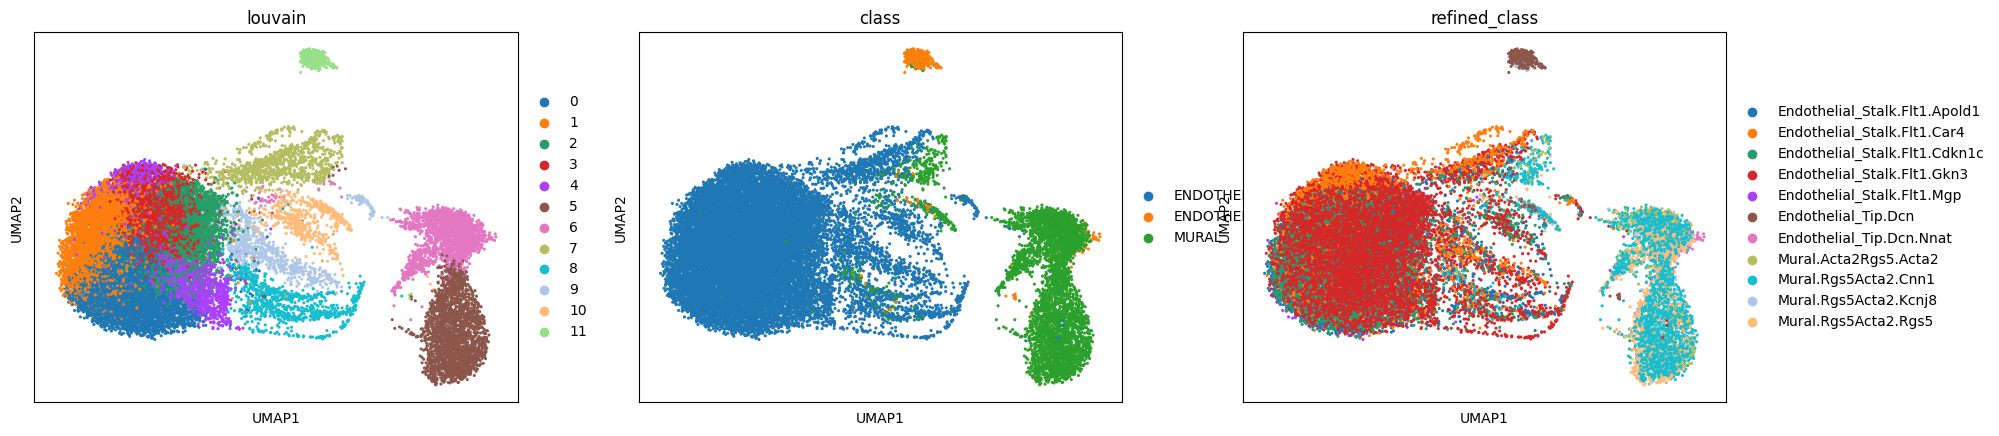

In [132]:
sc.pl.umap(adata_endo, color=['louvain', 'class', 'refined_class'],size=20)

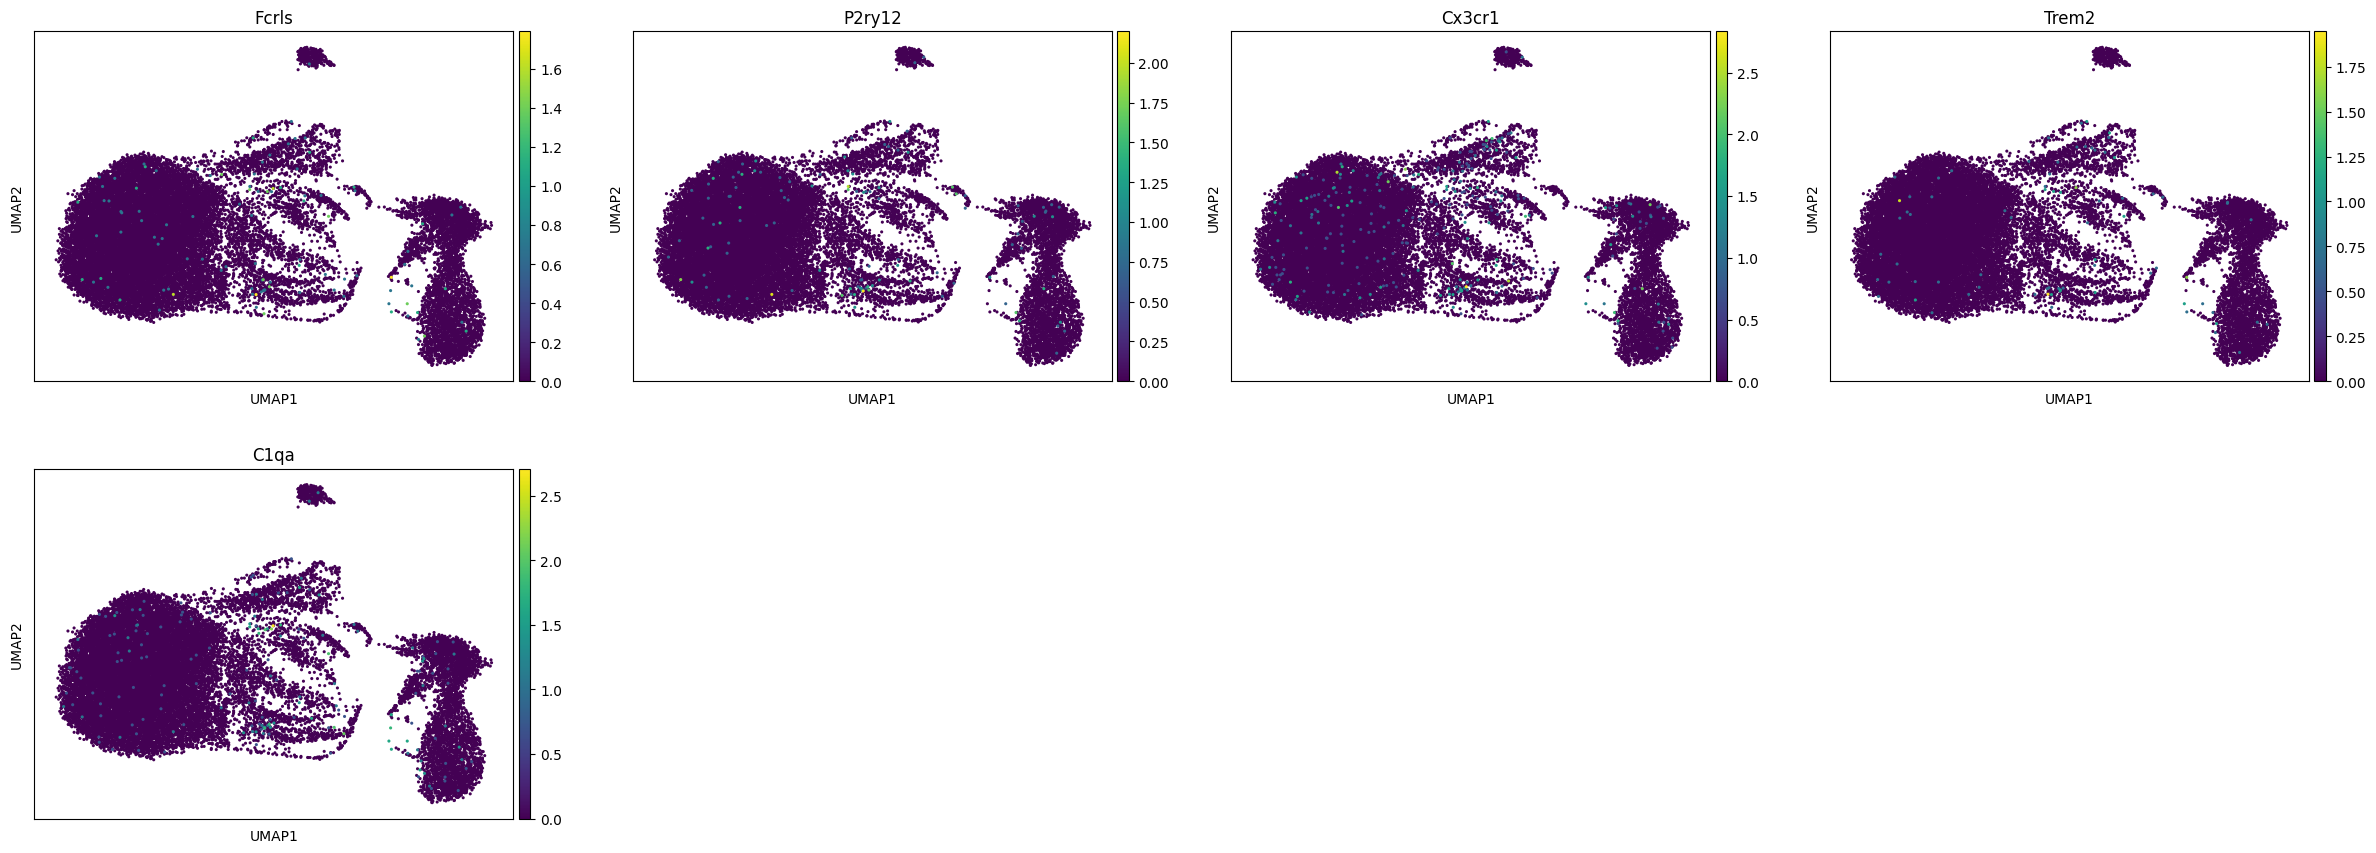

In [133]:
sc.pl.umap(adata_endo, color=['Fcrls', 'P2ry12','Cx3cr1', 'Trem2','C1qa'], size=20)#microglia marker

In [134]:
sc.tl.rank_genes_groups(adata_endo, 'louvain')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_louvain']`


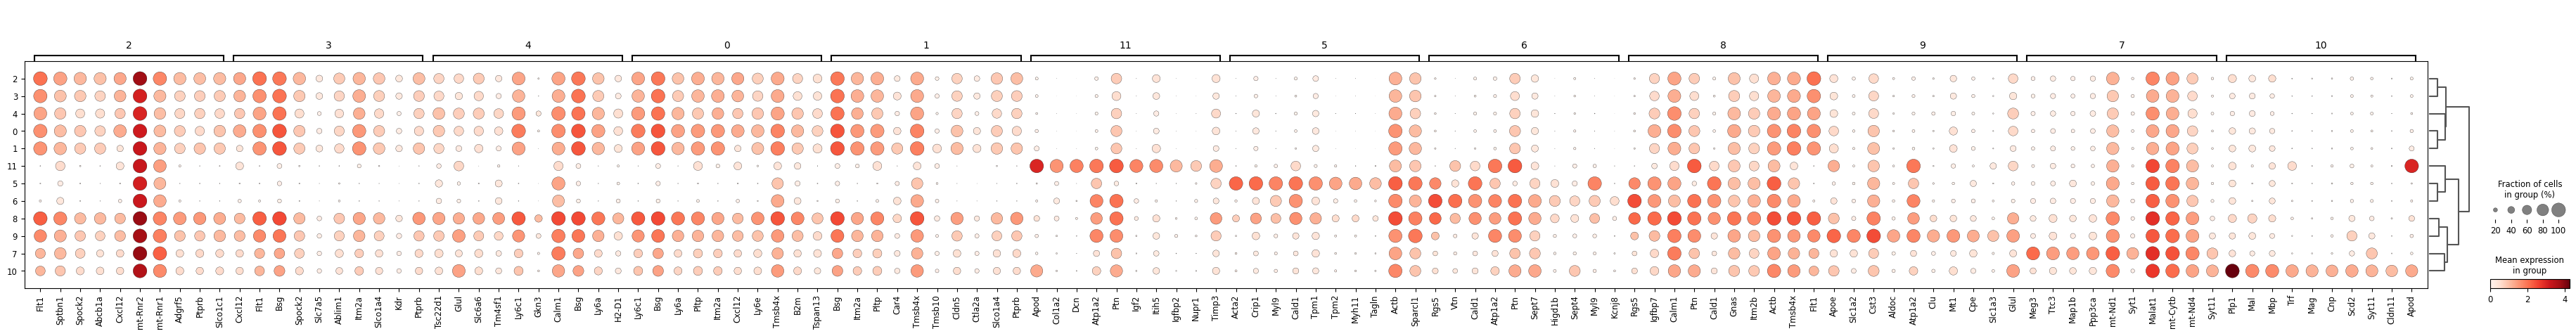

In [135]:
sc.pl.rank_genes_groups_dotplot(adata_endo)

**COMMENTS**: Cluster 16 is a microglia cell cluster. Cluster 13 belongs to oligodendrocytes (Plp1 marker). Cluster 17 is astrocytes (comparison to Tabula Muris). Cluster 4, 6 and 10 are pericytes. 

Let us re-annotate these clusters in the main data set.

In [136]:
tmp = adata_endo.obs['louvain']=='16'

microglia_index = adata_endo.obs['louvain'].loc[tmp].index

tmp = adata_endo.obs['louvain']=='17'

astrocyte_index = adata_endo.obs['louvain'].loc[tmp].index

tmp = np.in1d(adata_endo.obs['louvain'], ['4','6', '10'])

pericyte_index = adata_endo.obs['louvain'].loc[tmp].index

Let us apply the rough annotation into: 
astrocyte, brain pericyte, ependymal cells, macrophage, microglial cell, neuron, (olfactory ensheathing cell), oligodendrocyte, oligodendrocyte precursor cells.

In [137]:
adata_saunders.obs['class'].cat.categories

Index(['CB_1-1-1', 'CB_10-1-1', 'CB_10-2-1', 'CB_10-3-1', 'CB_11-1-1',
       'CB_11-2-1', 'CB_11-3-1', 'CB_11-4-1', 'CB_11-5-1', 'CB_2-1-1',
       ...
       'ENDOTHELIAL_STALK', 'ENDOTHELIAL_TIP', 'EPENDYMAL', 'MACROPHAGE',
       'MICROGLIA', 'MURAL', 'NEUROGENESIS', 'NEURON', 'OLIGODENDROCYTE',
       'POLYDENDROCYTE'],
      dtype='object', length=596)

In [138]:
saunders_rough_dict = dict({'ASTROCYTE' : 'astrocyte', 
                            'ENDOTHELIAL_STALK' : 'endothelial cell', 
                            'ENDOTHELIAL_TIP': 'endothelial cell', 
                            'EPENDYMAL': 'ependymal cell' ,
                            'MACROPHAGE': 'macrophage', 
                            'MICROGLIA' : 'microglial cell',
                            'MURAL': 'endothelial cell',
                            'NEUROGENESIS': 'neuron',
                            'NEURON' : 'neuron',
                            'OLIGODENDROCYTE': 'oligodendrocyte', 
                            'POLYDENDROCYTE' : 'oligodendrocyte precursor cell'})
df1 = pd.DataFrame.from_dict(saunders_rough_dict, orient='index')

In [139]:
np.unique(df1[0])

array(['astrocyte', 'endothelial cell', 'ependymal cell', 'macrophage',
       'microglial cell', 'neuron', 'oligodendrocyte',
       'oligodendrocyte precursor cell'], dtype=object)

In [140]:
adata_saunders.obs['cell_type'] = adata_saunders.obs['class'].cat.add_categories(['astrocyte', 
                            'endothelial cell', 'ependymal cell', 'macrophage',
       'microglial cell', 'neuron', 'oligodendrocyte',
       'oligodendrocyte precursor cell', 'brain pericyte'])

In [141]:
for idx in enumerate(df1[0]):
    adata_saunders.obs['cell_type'].loc[adata_saunders.obs['cell_type']==df1[0].index[idx[0]]] = idx[1]
    


In [142]:
adata_saunders.obs['cell_type'][microglia_index] = 'microglial cell'
adata_saunders.obs['cell_type'][astrocyte_index] = 'astrocyte'
adata_saunders.obs['cell_type'][pericyte_index] = 'brain pericyte'

adata_saunders.obs['cell_type'] = adata_saunders.obs['cell_type'].cat.remove_unused_categories()

In [143]:
pd.value_counts(adata_saunders.obs['cell_type'])

neuron             121777
PC_2-1-1            29071
oligodendrocyte     26982
astrocyte           21762
CB_1-1-1            21331
                    ...  
PC_15-1-1               2
STR_17-1-1              2
TH_15-1-1               1
ENT_17-1-1              1
GP_15-1-1               1
Name: cell_type, Length: 594, dtype: int64

In [144]:
adata_saunders.obs['study'] = 'Saunders'

In [145]:
sc.write(adata=adata_saunders, filename='saunders_regions.h5ad')

Free memory.

In [ ]:
del adata_saunders
del adata_endo

## Rosenberg et al (2018)

Rosenberg et al (2018) provided a convenience function written in Python to load their annotated dataset. **Comment:** I love it. The following lines adapt the code of the convenience function.

In [ ]:
import scipy.io as sio
import pandas as pd

In [ ]:
#Load Data
data = sio.loadmat('./../../DL_annotation/mouse_brain_data/Rosenberg_2018/GSM3017261_nuclei.mat')

#Digital Expression Matrix
DGE = data['DGE']

#Genes
genes = pd.Series(data['genes']).str.strip(' ')

#Sample types
sample_type = pd.Series(data['sample_type']).str.strip(' ')

#Main cluster assignment
cluster_assignment = pd.Series(data['cluster_assignment']).str.strip(' ')

#Spinal cluster assignment
spinal_cluster_assignment = pd.Series(data['spinal_cluster_assignment']).str.strip(' ')

Create an anndata object from the Rosenberg dataset.

Re-annotate the data, but focus on brain tissue.

In [ ]:
import numpy as np
brain_idx = np.isin(sample_type, ['p2_brain', 'p11_brain'])

In [ ]:
adata_rosen = anndata.AnnData(X=DGE[brain_idx,:])
adata_rosen.var_names=genes
adata_rosen.obs['sample_type']=sample_type[brain_idx].values
adata_rosen.obs['cluster'] = cluster_assignment[brain_idx].values

In [ ]:
adata_rosen.obs['age'] = np.array([types.split('_')[0] for types in adata_rosen.obs['sample_type']])

In [ ]:
adata_rosen
print(adata_rosen.X)

In [ ]:
rcParams['figure.figsize']=(10,10)
sc.pl.violin(adata_rosen, 'Plp1', groupby='cluster')

The annotation of the cells is encoded in the `cluster` variable. The neuronal cell types carry a region tag, others don't. In the next step, I split the cell type annotation into the region, if possible, and the respective cell type. 

In [ ]:
tmp = np.array([types.split(' ') for types in adata_rosen.obs['cluster']])

In [ ]:
adata_rosen.obs['cluster_id'] = np.array([types[0] for types in tmp])
adata_rosen.obs['region'] = np.array([types[1] for types in tmp])

In [ ]:
adata_rosen.obs['region'] = adata_rosen.obs['region'].astype('category')

We extract the region information as well as possible. The available regions are:

* HIPP - Hippocampus
* SUB - belongs to Hippocampus
* THAL - Thalamus
* CTX - Cortex
* OB - Olfactory bulb
* Medium - 'Medium spiny neurons' from Striatum (STR)
* CLAU - belongs to Cortex
* CB - cerebellum
* Purkinje - assigned to cerebellum
* MTt - Rostral midbrain (MB)
* MD - medulla
* Nigral - Nigral dopaminergic neurons from Substantia nigra (SN)
* Migrating - interneurons, which we assign to cerebellum (CB)
* SVZ - subventricular zone, close to striatum (STR)
* SC - spinal cord
* OEC - macroglia, which reside in the olfactory bulb

Create a dictionary to assign the regions.

In [ ]:
neuro_dict = dict({'HIPP': 'HC', 
                   'SUB' : 'HC', 
                   'THAL' : 'TH', 
                   'Medium' : 'STR',
                   'CLAU' : 'CTX', 
                   'Purkinje' : 'CB', 
                   'MTt' : 'MB',
                   'Nigral' : 'SN',
                   'Migrating': 'CB',
                   'SVZ' : 'STR',
                   'OEC' : 'OB'
                  })

df = pd.DataFrame.from_dict(neuro_dict, orient='index')


In [ ]:
adata_rosen.obs['region'] = adata_rosen.obs['region'].cat.add_categories([ 'HC', 'MB', 'STR', 'TH', 'SN'])

for idx in enumerate(df[0]):
    adata_rosen.obs['region'].loc[adata_rosen.obs['region']==df[0].index[idx[0]]] = idx[1]
    
adata_rosen.obs['region'] = adata_rosen.obs['region'].cat.remove_unused_categories()

Next, we remove all categories, where we do not have a region information. 

In [ ]:
unknown_region = list(set(adata_rosen.obs['region'].cat.categories) - set(np.unique(df[0])) - set(['OB', 'MD', 'SC']))

In [ ]:
adata_rosen.obs['region'] = adata_rosen.obs['region'].cat.add_categories(['Unknown'])

for idx in enumerate(unknown_region):
    adata_rosen.obs['region'].loc[adata_rosen.obs['region']==idx[1]] = 'Unknown'
    
adata_rosen.obs['region'] = adata_rosen.obs['region'].cat.remove_unused_categories()

In [ ]:
adata_rosen.obs['region'].value_counts()

In [ ]:
adata_rosen

In [ ]:
sc.write(adata=adata_rosen, filename='rosenberg_regions.h5ad')

Rename and merge clusters.

In [ ]:
adata_rosen.obs['cell_type'] = adata_rosen.obs['cluster'].cat.add_categories(['astrocyte', 
       'brain pericyte', 'endothelial cell', 'ependymal cell', 'olfactory ensheathing cell',
       'macrophage', 'microglial cell', 'neuron',
       'oligodendrocyte', 'oligodendrocyte precursor cell'])

adata_rosen.obs['cell_type'][np.in1d(adata_rosen.obs['cluster'], 
                                     ['61 OPC'])] = np.repeat(
    'oligodendrocyte precursor cell', np.in1d(adata_rosen.obs['cell_type'], 
            ['61 OPC']).sum())

adata_rosen.obs['cell_type'][np.in1d(adata_rosen.obs['cluster'], 
                                     ['1 OB Mitral/Tufted Eomes', '2 OB Mitral/Tufted Ms4a15',
       '3 OB Mitral/Tufted Svil', '4 Medium Spiny Neurons',
       '5 CTX PyrL2/L3 Pappa2', '6 CTX PyrL2/L3/L4 Ntf3', '7 CTX PyrL2/L3 Met',
       '8 CTX PyrL4 Wnt5b', '9 CTX PyrL2/L3/L4 Mef2c', '10 CTX PyrL4 Rorb',
       '11 CTX PyrL4/L5', '12 CTX PyrL5 Itgb3', '13 CTX PyrL5 Fezf2',
       '14 CTX PyrL6a', '15 CTX PyrL5/L6 Sulf1', '16 CTX PyrL5/L6 Npr3',
       '17 CTX PyrL6', '18 CLAU Pyr', '19 MTt Glut', '20 THAL Glut',
       '21 THAL Int Six3', '22 Purkinje Early', '23 Purkinje Late',
       '24 CB Int Progenitor', '25 CB Granule Precursor',
       '26 CB Int Stellate/Basket', '27 CB Int Golgi/Stellate/Basket',
       '28 CB Granule', '29 CB Int Precursor', '30 MD Glyc Int',
       '31 MD Int Rxfp2', '32 Nigral Dopaminergic', '33 HIPP Pyr Cr2',
       '34 SUB Pyr', '35 HIPP Pyr Crym', '36 HIPP Granule Mki67',
       '37 HIPP Pyr Precursor', '38 HIPP Pyr Grik4', '39 HIPP Granule Nrp2',
       '40 HIPP Granule/PyrCA3', '41 HIPP Pyr Npy2r', '42 SC Glut Hmga2',
       '43 SC Glut Gna14', '44 Migrating Int Lhx6', '45 Migrating Int Trdn',
       '46 Migrating Int Cpa6', '47 Migrating Int Foxp2',
       '48 Migrating Int Pbx3', '49 Migrating Int Lgr6',
       '50 Migrating Int Adarb2', '51 SVZ Stem', '52 Cajal-Retzius',
       '53 Unresolved', '54 Unresolved Kcng1',])] = np.repeat(
    'neuron', np.in1d(adata_rosen.obs['cell_type'], 
            ['1 OB Mitral/Tufted Eomes', '2 OB Mitral/Tufted Ms4a15',
       '3 OB Mitral/Tufted Svil', '4 Medium Spiny Neurons',
       '5 CTX PyrL2/L3 Pappa2', '6 CTX PyrL2/L3/L4 Ntf3', '7 CTX PyrL2/L3 Met',
       '8 CTX PyrL4 Wnt5b', '9 CTX PyrL2/L3/L4 Mef2c', '10 CTX PyrL4 Rorb',
       '11 CTX PyrL4/L5', '12 CTX PyrL5 Itgb3', '13 CTX PyrL5 Fezf2',
       '14 CTX PyrL6a', '15 CTX PyrL5/L6 Sulf1', '16 CTX PyrL5/L6 Npr3',
       '17 CTX PyrL6', '18 CLAU Pyr', '19 MTt Glut', '20 THAL Glut',
       '21 THAL Int Six3', '22 Purkinje Early', '23 Purkinje Late',
       '24 CB Int Progenitor', '25 CB Granule Precursor',
       '26 CB Int Stellate/Basket', '27 CB Int Golgi/Stellate/Basket',
       '28 CB Granule', '29 CB Int Precursor', '30 MD Glyc Int',
       '31 MD Int Rxfp2', '32 Nigral Dopaminergic', '33 HIPP Pyr Cr2',
       '34 SUB Pyr', '35 HIPP Pyr Crym', '36 HIPP Granule Mki67',
       '37 HIPP Pyr Precursor', '38 HIPP Pyr Grik4', '39 HIPP Granule Nrp2',
       '40 HIPP Granule/PyrCA3', '41 HIPP Pyr Npy2r', '42 SC Glut Hmga2',
       '43 SC Glut Gna14', '44 Migrating Int Lhx6', '45 Migrating Int Trdn',
       '46 Migrating Int Cpa6', '47 Migrating Int Foxp2',
       '48 Migrating Int Pbx3', '49 Migrating Int Lgr6',
       '50 Migrating Int Adarb2', '51 SVZ Stem', '52 Cajal-Retzius',
       '53 Unresolved', '54 Unresolved Kcng1',]).sum())


adata_rosen.obs['cell_type'][np.in1d(adata_rosen.obs['cluster'], 
                                     ['55 Oligo MFOL2',
       '56 Oligo MFOL1', '57 Oligo MOL', '58 Oligo NFOL1', '59 Oligo COP1',
       '60 Oligo COP2'])] = np.repeat(
    'oligodendrocyte', np.in1d(adata_rosen.obs['cell_type'], 
            ['55 Oligo MFOL2',
       '56 Oligo MFOL1', '57 Oligo MOL', '58 Oligo NFOL1', '59 Oligo COP1',
       '60 Oligo COP2']).sum())

adata_rosen.obs['cell_type'][np.in1d(adata_rosen.obs['cluster'], 
                                     ['63 Microglia'])] = np.repeat(
    'microglial cell', np.in1d(adata_rosen.obs['cell_type'], 
            ['63 Microglia']).sum())

adata_rosen.obs['cell_type'][np.in1d(adata_rosen.obs['cluster'], 
                                     ['62 Macrophage'])] = np.repeat(
    'macrophage', np.in1d(adata_rosen.obs['cell_type'], 
            ['62 Macrophage']).sum())

adata_rosen.obs['cell_type'][np.in1d(adata_rosen.obs['cluster'], 
                                     ['72 Ependyma'])] = np.repeat(
    'ependymal cell', np.in1d(adata_rosen.obs['cell_type'], 
            ['72 Ependyma']).sum())

adata_rosen.obs['cell_type'][np.in1d(adata_rosen.obs['cluster'], 
                                     ['68 Astro Slc7a10', '69 Astro Prdm16', '70 Astro Gfap',
       '71 Bergmann Glia'])] = np.repeat(
    'astrocyte', np.in1d(adata_rosen.obs['cell_type'], 
            ['68 Astro Slc7a10', '69 Astro Prdm16', '70 Astro Gfap',
       '71 Bergmann Glia']).sum())

adata_rosen.obs['cell_type'][np.in1d(adata_rosen.obs['cluster'], 
                                     ['64 Endothelia'])] = np.repeat(
    'endothelial cell', np.in1d(adata_rosen.obs['cell_type'], 
            ['64 Endothelia']).sum())

adata_rosen.obs['cell_type'][np.in1d(adata_rosen.obs['cluster'], 
                                     ['65 SMC', '66 VLMC Slc6a13', '67 VLMC Slc47a1'])] = np.repeat(
    'brain pericyte', np.in1d(adata_rosen.obs['cell_type'], 
            ['65 SMC', '66 VLMC Slc6a13', '67 VLMC Slc47a1']).sum())

adata_rosen.obs['cell_type'][np.in1d(adata_rosen.obs['cluster'], 
                                     ['73 OEC'])] = np.repeat(
    'olfactory ensheathing cell', np.in1d(adata_rosen.obs['cell_type'], 
            ['73 OEC']).sum())


adata_rosen.obs['cell_type'] = adata_rosen.obs['cell_type'].cat.remove_unused_categories()


In [ ]:
adata_rosen.obs['cell_type'].cat.categories

In [ ]:
adata_rosen.obs['cell_type'].value_counts()

In [ ]:
adata_rosen.obs['study'] = 'Rosenberg'

In [ ]:
adata_rosen

In [ ]:
sc.write(adata=adata_rosen, filename='rosenberg_regions.h5ad')

## Zeisel et al (2018)

Systematic survey of transcriptomic cell types in the mouse nervous system with over 500k cells (reported, only 160k in the loom file).
Date were stored as `loom` files.

In [ ]:
adata_zeisel = sc.read_loom('./../../DL_annotation/mouse_brain_data/Zeisel_2018/l5_all.loom')

In [ ]:
adata_zeisel.obs_names_make_unique()
adata_zeisel.var_names_make_unique()

In [ ]:
adata_zeisel

In [ ]:
pd.value_counts(adata_zeisel.obs['Taxonomy_group'])

In [ ]:
adata_zeisel.obs['Region'].astype('category').values

In [ ]:
pd.value_counts(adata_zeisel.obs['Age'])

In [ ]:
pd.value_counts(adata_zeisel.obs['Subclass'])

Assign regions to the already present brain structures:
* Amygdala - Amygdala (AMY)
* CA1 - Hippocampus (HC)
* Ctx1, Ctx1.5, Ctx2, Ctx3 - Cortex (CTX)
* DRG - Dorsal root ganglia (**to exclude**)
* DentGyr - Dentate Gyrus (to Hippocampus)
* ENS - Enteric nervous system (**to exclude**)
* HC - Hippocampus
* Hypoth - Hypothalamus (HTH)
* MBd, MBv - midbrain dorsal, ventral (merge to midbrain, MB)
* Medulla - MD
* OB - olfactory bulb
* Pons - PO 
* SC - spinal cord 
* SScortex - secondary somatosensensory cortex - Cortex (CTX)
* StriatDor, StriatVent - Striatum (STR)
* Sympath - Sympathetic ganglion (**to exclude**)
* Thal - Thalamus (TH)

In [ ]:
adata_zeisel.obs['Tissue'].astype('category').values

In [ ]:
region_dict = dict({'Amygd': 'AMY', 
                    'CA1' : 'HC', 
                    'Ctx1': 'CTX', 
                    'Ctx1.5': 'CTX', 
                    'Ctx2': 'CTX', 
                    'Ctx3': 'CTX', 
                    #'DRG',
                    'DentGyr' : 'HC', 
                    #'ENS', 
                    'Hypoth' : 'HTH', 
                    'MBd' : 'MB', 
                    'MBv' : 'MB', 
                    'Medulla' : 'MD', 
                    'Pons' : 'PO',
                    'SScortex' : 'CTX', 
                    'StriatDor' : 'STR', 
                    'StriatVent': 'STR',
                    #'Sympath', 
                    'Thal' : 'TH'})

df = pd.DataFrame.from_dict(region_dict, orient='index')

In [ ]:
adata_zeisel.obs['region'] = adata_zeisel.obs['Tissue'].astype('category').cat.add_categories(np.unique(
        ['AMY', 'CTX', 'HTH', 'MB', 'MD', 'PO', 'STR', 'TH']))
# adata_zeisel.obs['region'] = adata_zeisel.obs['Tissue'].add_categories(np.unique(
#         ['AMY', 'CTX', 'HTH', 'MB', 'MD', 'PO', 'STR', 'TH']))

for idx in enumerate(df[0]):
    adata_zeisel.obs['region'].loc[adata_zeisel.obs['region']==df[0].index[idx[0]]] = idx[1]
    
adata_zeisel.obs['region'] = adata_zeisel.obs['region'].cat.remove_unused_categories()

Exclude `DRG`, `ENS` and `Sympath` cells.

In [ ]:
adata_zeisel = adata_zeisel[np.invert(np.in1d(adata_zeisel.obs['region'], ['DRG', 'ENS', 'Sympath']))].copy()

In [ ]:
adata_zeisel.obs['region'].value_counts()

In [ ]:
pd.value_counts(adata_zeisel.obs['Subclass'])

In [ ]:
pd.crosstab(adata_zeisel.obs['Taxonomy_group'],adata_zeisel.obs['Subclass'])

In [ ]:
adata_zeisel

In [ ]:
del adata_zeisel.obs['Region']

Let us use the `Taxonomy_group` of `adata_zeisel` as a new variable `cell_type`. Then, *oligos* are renamed to *oligodendrocytes*, *vascular* becomes *endothelial cell*. The *Immune* cells are a mixture of *macrophages* and *microglia*. We have to check the *Peripheral glia* and *Ependymal*, which have no correspondence in the other datasets. However, microglia are apparently missing in the dataset.  

In [ ]:
sc.pl.violin(adata_zeisel, ['Lyz2', 'Ctss', 'Cd74'], groupby='Taxonomy_group')

**Conclusion** Peripheral Glia have most overlap with brain pericytes and we keep the ependymal cells as extra category.

In [ ]:
adata_zeisel.obs['Taxonomy_group'].cat.categories

In [ ]:
adata_zeisel.obs['cell_type'] = adata_zeisel.obs['Taxonomy_group'].cat.add_categories(['astrocyte', 
        'brain pericyte', 'endothelial cell','ependymal cell','neuron',
       'macrophage', 'microglial cell', 'oligodendrocyte',
                     'oligodendrocyte precursor cell',
                         'olfactory ensheathing cell', ])

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Astrocytes','Subventricular zone radial glia-like cells',
                                     'Dentate gyrus radial glia-like cells'])] =  'astrocyte'
adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Ependymal cells', 
                                      'Subcommissural organ hypendymal cells'])] = 'ependymal cell'
         
adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Perivascular macrophages'])] = 'macrophage'
adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Microglia'])] = 'microglial cell'
           
adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Telencephalon inhibitory interneurons',
       'Telencephalon projecting excitatory neurons',
       'Telencephalon projecting inhibitory neurons', 
                                      'Di- and mesencephalon excitatory neurons',
       'Di- and mesencephalon inhibitory neurons',
                                      'Cerebellum neurons',
       'Cholinergic and monoaminergic neurons',
                                      'Dentate gyrus granule neurons',
                                      'Non-glutamatergic neuroblasts',
                                      'Glutamatergic neuroblasts', 'Hindbrain neurons',
                                      'Spinal cord excitatory neurons',
                                      'Olfactory inhibitory neurons',
                                      'Peptidergic neurons',
       'Spinal cord inhibitory neurons'])] = 'neuron'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Oligodendrocytes'])] = 'oligodendrocyte'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Oligodendrocyte precursor cells'])] = 'oligodendrocyte precursor cell'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Olfactory ensheathing cells'])] = 'olfactory ensheathing cell'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Pericytes'])] = 'brain pericyte'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Vascular and leptomeningeal cells', 'Vascular endothelial cells',
       'Vascular smooth muscle cells', 'Choroid epithelial cells'])] = 'endothelial cell'

adata_zeisel.obs['cell_type'] = adata_zeisel.obs['cell_type'].cat.remove_unused_categories()


In [ ]:
adata_zeisel.obs['cell_type'].value_counts()

In [ ]:
adata_zeisel.obs['study'] = 'Zeisel'

In [ ]:
##Keep tissue, subclass, age and region.
#adata_zeisel.obs['Region']
#adata_zeisel.obs['Age']
#adata_zeisel.obs['Subclass']
#adata_zeisel.obs['Tissue']

In [ ]:
del adata_zeisel.obs['AnalysisPool']
del adata_zeisel.obs['AnalysisProject']
del adata_zeisel.obs['Bucket']
del adata_zeisel.obs['CellConc']
del adata_zeisel.obs['Cell_Conc']
del adata_zeisel.obs['ChipID']
del adata_zeisel.obs['Class']
del adata_zeisel.obs['ClassProbability_Astrocyte']
del adata_zeisel.obs['ClassProbability_Astrocyte,Immune']
del adata_zeisel.obs['ClassProbability_Astrocyte,Neurons']
del adata_zeisel.obs['ClassProbability_Astrocyte,Oligos']
del adata_zeisel.obs['ClassProbability_Astrocyte,Vascular']
del adata_zeisel.obs['ClassProbability_Bergmann-glia']
del adata_zeisel.obs['ClassProbability_Blood']
del adata_zeisel.obs['ClassProbability_Blood,Vascular']
del adata_zeisel.obs['ClassProbability_Enteric-glia']
del adata_zeisel.obs['ClassProbability_Enteric-glia,Cycling']
del adata_zeisel.obs['ClassProbability_Ependymal']
del adata_zeisel.obs['ClassProbability_Ex-Neurons']
del adata_zeisel.obs['ClassProbability_Ex-Vascular']
del adata_zeisel.obs['ClassProbability_Immune']
del adata_zeisel.obs['ClassProbability_Immune,Neurons']
del adata_zeisel.obs['ClassProbability_Immune,Oligos']
del adata_zeisel.obs['ClassProbability_Neurons']
del adata_zeisel.obs['ClassProbability_Neurons,Cycling']
del adata_zeisel.obs['ClassProbability_Neurons,Oligos']
del adata_zeisel.obs['ClassProbability_Neurons,Satellite-glia']
del adata_zeisel.obs['ClassProbability_Neurons,Vascular']
del adata_zeisel.obs['ClassProbability_OEC']
del adata_zeisel.obs['ClassProbability_Oligos']
del adata_zeisel.obs['ClassProbability_Oligos,Cycling']
del adata_zeisel.obs['ClassProbability_Oligos,Vascular']
del adata_zeisel.obs['ClassProbability_Satellite-glia']
del adata_zeisel.obs['ClassProbability_Satellite-glia,Cycling']
del adata_zeisel.obs['ClassProbability_Satellite-glia,Schwann']
del adata_zeisel.obs['ClassProbability_Schwann']
del adata_zeisel.obs['ClassProbability_Ttr'] 
del adata_zeisel.obs['ClassProbability_Vascular']
del adata_zeisel.obs['ClusterName']
del adata_zeisel.obs['Clusters']
del adata_zeisel.obs['Comment']
del adata_zeisel.obs['Comments']
del adata_zeisel.obs['DateCaptured']
del adata_zeisel.obs['Date_Captured']
del adata_zeisel.obs['Description']
del adata_zeisel.obs['Developmental_compartment']
del adata_zeisel.obs['DonorID']
del adata_zeisel.obs['Estimated Number of Cells']
del adata_zeisel.obs['Flowcell']
del adata_zeisel.obs['Fraction Reads in Cells']
del adata_zeisel.obs['Label']
del adata_zeisel.obs['LeafOrder']
del adata_zeisel.obs['Location_based_on']
del adata_zeisel.obs['Mean Reads per Cell']
del adata_zeisel.obs['Median Genes per Cell']
del adata_zeisel.obs['Median UMI Counts per Cell']
del adata_zeisel.obs['MitoRiboRatio']
del adata_zeisel.obs['NGI_PlateWell']
del adata_zeisel.obs['Neurotransmitter']
del adata_zeisel.obs['NumPooledAnimals']
del adata_zeisel.obs['Num_Pooled_Animals']
del adata_zeisel.obs['Number of Reads']
del adata_zeisel.obs['OriginalClusters']
del adata_zeisel.obs['Outliers']
del adata_zeisel.obs['PCRCycles']
del adata_zeisel.obs['PCR_Cycles']
del adata_zeisel.obs['PassedQC']
del adata_zeisel.obs['PlugDate']
del adata_zeisel.obs['Plug_Date']
del adata_zeisel.obs['Probable_location']
del adata_zeisel.obs['Project']
del adata_zeisel.obs['Q30 Bases in Barcode']
del adata_zeisel.obs['Q30 Bases in RNA Read']
del adata_zeisel.obs['Q30 Bases in Sample Index']
del adata_zeisel.obs['Q30 Bases in UMI']
del adata_zeisel.obs['Reads Mapped Confidently to Exonic Regions']

In [ ]:
del adata_zeisel.obs['Reads Mapped Confidently to Intergenic Regions']
del adata_zeisel.obs['Reads Mapped Confidently to Intronic Regions']
del adata_zeisel.obs['Reads Mapped Confidently to Transcriptome']
del adata_zeisel.obs['SampleID']
del adata_zeisel.obs['SampleIndex']
del adata_zeisel.obs['SampleOK']
del adata_zeisel.obs['Sample_Index']
del adata_zeisel.obs['SeqComment']
del adata_zeisel.obs['SeqLibDate']
del adata_zeisel.obs['SeqLibOk']
del adata_zeisel.obs['Seq_Comment']
del adata_zeisel.obs['Seq_Lib_Date']
del adata_zeisel.obs['Seq_Lib_Ok']
del adata_zeisel.obs['Sequencing Saturation']
del adata_zeisel.obs['Serial_Number']
del adata_zeisel.obs['Sex']
del adata_zeisel.obs['Species']
del adata_zeisel.obs['Strain']
del adata_zeisel.obs['TargetNumCells']
del adata_zeisel.obs['Target_Num_Cells']
del adata_zeisel.obs['TaxonomyRank1']
del adata_zeisel.obs['TaxonomyRank2']
del adata_zeisel.obs['TaxonomyRank3']
del adata_zeisel.obs['TaxonomyRank4']
del adata_zeisel.obs['TaxonomySymbol']
del adata_zeisel.obs['TimepointPool']
del adata_zeisel.obs['Total Genes Detected']
del adata_zeisel.obs['Transcriptome']
del adata_zeisel.obs['Valid Barcodes']
del adata_zeisel.obs['_KMeans_10']
del adata_zeisel.obs['_LogCV']
del adata_zeisel.obs['_LogMean']
del adata_zeisel.obs['_NGenes']
del adata_zeisel.obs['_PC1']
del adata_zeisel.obs['_PC2']
del adata_zeisel.obs['_Total']
del adata_zeisel.obs['_Valid']
del adata_zeisel.obs['_X']
del adata_zeisel.obs['_Y']
del adata_zeisel.obs['_tSNE1']
del adata_zeisel.obs['_tSNE2']
del adata_zeisel.obs['cDNAConcNanogramPerMicroliter']
del adata_zeisel.obs['cDNALibOk']
del adata_zeisel.obs['cDNA_Lib_Ok']
del adata_zeisel.obs['ngperul_cDNA']

In [ ]:
del adata_zeisel.var['Accession']
del adata_zeisel.var['_LogCV']
del adata_zeisel.var['_LogMean']
del adata_zeisel.var['_Selected']
del adata_zeisel.var['_Total']
del adata_zeisel.var['_Valid']

In [ ]:
adata_zeisel

In [ ]:
sc.write(adata=adata_zeisel, filename='zeisel_regions.h5ad')